In [47]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from pandas import DataFrame
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import MinMaxScaler
import operator

from sklearn.cluster import KMeans
import mahotas as mt


# Loading the Dataset

In [48]:
file_path = 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories'
folder_names = []
folder_names = [f for f in sorted(os.listdir(file_path))]

print(len(folder_names))  # 102 = 101 categories + background


102


C:\Users\Joe\AppData\Local\Temp\ipykernel_4660\2155978937.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


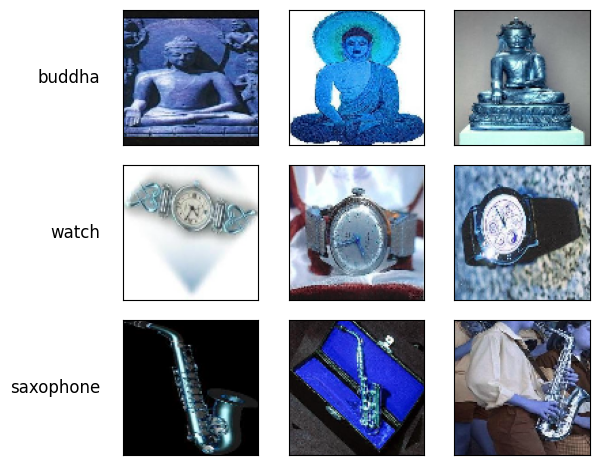

In [49]:
num_categories = 3
num_imgs = 3 
selected_categories = np.random.randint(0,101, num_categories, dtype="I")

fig, ax = plt.subplots(nrows=num_categories, ncols=num_imgs)

fig.subplots_adjust(wspace=0.1,hspace=0.1)

for a, cat in enumerate(selected_categories):
    folder_path = file_path + '/' + folder_names[cat]
    image_names = [a for a in sorted(
        os.listdir(folder_path))][:num_imgs]
    
    for b, img_name in enumerate(image_names):
        img_path = folder_path + '/' + img_name
        img = cv2.imread(img_path)
        img = cv2.resize(img, (100, 100))
        ax[a, b].imshow(img)
        ax[a, b].set_xticks([])
        ax[a, b].set_yticks([])
        
        if b == 0:
            pad = 5  # in points
            #ax[i,j].set_ylabel(folder_names[category], rotation=0, size='large')
            ax[a,b].annotate(folder_names[cat], xy=(0, 0.5), xytext=(-ax[a,b].yaxis.labelpad - pad, 0),
                xycoords=ax[a,b].yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
        
fig.tight_layout()
#plt.axis('off')
fig.show()


In [50]:
img_data = []
img_money = []
num_categories = 6
num_imgs = 9
selected_categories = np.random.randint(0,101, num_categories, dtype="I")

for a, cat in enumerate(selected_categories):
    folder_path = file_path + '/' + folder_names[cat]
    image_names = [a for a in sorted(
        os.listdir(folder_path))][:num_imgs]

    for b, img_name in enumerate(image_names):
        img_path = folder_path + '/' + img_name
        img_money.append(img_path)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (100, 100))
        
        if img is not None:
            img_data.append(img)
       


# Global Functions

In [51]:
def normalise(distances, scale):
    scaler = MinMaxScaler((0, scale))
    keys = distances.keys()
    distances = np.array(list(distances.values()))
    distances = scaler.fit_transform(distances.reshape(-1, 1))
    distances = dict(zip(keys, distances))
    return distances

# Histogram features

In [52]:
def histogram_features(img):
    features = [] 
    pp_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    channels = cv2.split(pp_img)
    channel_names = ('h', 's', 'v')
    for (channel, channel_name) in zip(channels, channel_names):
        hist = cv2.calcHist([channel], [0], None, [256], [0, 256])
        features.extend(hist.flatten())
        return features

In [53]:
def hist_features_database(data_imgs):
    db_features = []
    for img in data_imgs:
        db_features.append(histogram_features(img))
    db_hist_df = DataFrame(db_features)
    return db_hist_df

In [54]:
def calc_hist_distance(query_img, db_df):
    feature_vectors = db_df.values.tolist()
    distances = {}
    for a in range(len(feature_vectors)):
        query_features = histogram_features(query_img)
        dist = euclidean(query_features, feature_vectors[a])
        distances[a] = dist
    return normalise(distances, 20)

In [55]:
test_hist = hist_features_database(img_data)


In [56]:
test_hist.shape

(54, 256)

# Gabor Features

In [57]:
def build_filters():
    filters = []
    kernal_size = 9 
    for theta in np.arange(0, np.pi, np.pi / 8):
        for deg in np.arange(0, 6*np.pi/4, np.pi / 4):
            kernal = cv2.getGaborKernel((kernal_size, kernal_size), 1.0, theta, deg, 0.5, 0, ktype= cv2.CV_32F)
            kernal /= 1.5 * kernal.sum()
            filters.append(kernal)
    return filters

In [58]:
jdwi = build_filters()
len(jdwi)


48

In [59]:
def convolve_filters(img, filters):
    conv = np.zeros_like(img)
    for kernal in filters:
        filter_img = cv2.filter2D(img, cv2.CV_8UC3, kernal)
        np.maximum(conv, filter_img, conv)
    return conv

In [60]:
def gabor_features(img):
    features = []
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    filters = np.asarray(build_filters())
    
    for a in range(20):
        energy = 0
        conv = convolve_filters(img, filters[a])
        for b in range(img.shape[0]):
            for c in range(img.shape[1]):
                energy += conv[b][c] * conv[b][c]
        features.append(energy)
    for a in range(20):
        mean = 0
        conv = convolve_filters(img, filters[a])
        for b in range(img.shape[0]):
            for c in range(img.shape[1]):
                mean += abs(conv[a][b])
        features.append(mean)
    features = np.array(features)
    return features

In [61]:
filters = np.asarray(build_filters())
test = convolve_filters(img, filters[20])


In [62]:
np.shape(test)


(100, 100, 3)

In [63]:
def gabor_features_database(data_imgs):
    db_feat = []
    for img in data_imgs:
        db_feat.append(gabor_features(img))
    db_gabor_df = DataFrame(db_feat)
    return db_gabor_df

In [64]:
def calc_gabor_distance(query_img, db_df):
    distances = {}
    query_feat = gabor_features(query_img)
    feature_vector = db_df.values.tolist()
    
    for a in range(len(feature_vector)):
        distances[a] = euclidean(query_feat, feature_vector[a])
    distances = normalise(distances, 20)
    return distances

# Haralick Feature Testing

In [65]:
def haralick_features(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    texture = mt.features.haralick(img)
    features = texture.mean(axis=0)
    return features

In [66]:
def haralick_features_database(img_db):
    features = []
    for img in img_db:
        feat = haralick_features(img)
        features.append(feat)
    haralick_df = DataFrame(features)
    return haralick_df


In [67]:
def calc_haralick_distance(query_img, db_df):
    distances = {}
    query_feat = haralick_features(query_img)
    haralick_fv = db_df.values.tolist()
    for a in range(len(haralick_fv)):
        img_feats = haralick_fv[a]
        dist = euclidean(query_feat, img_feats)
        distances[a] = dist
    distances = normalise(distances, 20)
    return distances

# Distance Metric Calculation

In [68]:
def calc_distances_total(hist_dist, gabor_dist):
    total_dist = []
    hist_weight = 0.8
    gabor_weight = 0.2
    
    for a in hist_dist:
        hist_dist[a] *= hist_weight
        gabor_dist[a] *= gabor_weight
        total_dist.append(hist_dist[a] + gabor_dist[a])  
    return sorted(dict(zip(np.arange(0, len(img_data)), (np.array(total_dist)))).items(), key=operator.itemgetter(1))


In [69]:
query_img = img_data[0]

hist_dist = calc_hist_distance(query_img, hist_features_database(img_data))
gabor_dist = calc_gabor_distance(query_img, gabor_features_database(img_data))

final_dist = calc_distances_total(hist_dist, gabor_dist)

C:\Users\Joe\AppData\Local\Temp\ipykernel_4660\1077438191.py:11: RuntimeWarning: overflow encountered in ubyte_scalars
  energy += conv[b][c] * conv[b][c]


# Model 2 Testing

# HOG

In [116]:
import skimage
from skimage.feature import hog

In [117]:
def HOG_features(img, bin_n, normalise = True):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    fd = hog(img, orientations=8, pixels_per_cell=(2,2), cells_per_block=(1,1))
    b = np.linspace(0, np.max(fd), bin_n+1)
    histogram, _ = np.histogram(fd, bins=b)
    
    if normalise:
        histogram = (histogram - histogram.mean()) / (histogram.std())
    
    return histogram

In [118]:
def HOG_hist(img, type_h, bin_n, slice_n, norm):
    
    if type_h == 'global':
        histogram = HOG_features(img, bin_n)
        
    elif type_h == 'reigon':
        histogram = np.zeros((slice_n, slice_n, bin_n))
        slice_h = np.around(np.linspace(0, img.shape[0], slice_n +1)).astype(int)
        slice_w = np.around(np.linspace(0, img.shape[1], slice_n + 1)).astype(int)
        
        for h in range(len(slice_h)-1):
            for w in range(len(slice_w)-1):
                #create reigons for image
                reigon = img[slice_h[h]:slice_h[h+1], slice_w[w]: slice_w[w+1]]
                histogram[h][w] = HOG_features(reigon, bin_n)
        
    if normalise:
        histogram /= np.sum(histogram)
            
    return histogram.flatten()


In [119]:
def HOG_db_feats(img_db, type_h, bin_n, slice_n, norm):
    db_features = []
    for img in img_db:
        db_features.append(HOG_hist(img, type_h, bin_n, slice_n, norm))
    db_df = DataFrame(db_features)
    return db_df

# Colour Features 2.0

In [120]:
import itertools
import imageio.v3 as iio


In [121]:
def colour_features2(img, bin_n, bins, c):
    temp_img = img.copy()
    bins_i = {key: ind for ind, key in enumerate(itertools.product(np.arange(bin_n), repeat=c))}
    histogram = np.zeros(bin_n ** c)
    
    #cluster pixels
    for a in range(len(bins)-1):
        temp_img[(img >= bins[a]) & (img < bins[a+1])] = a
        
    for h in range(temp_img.shape[0]):
        for w in range(temp_img.shape[1]):
            ind_b = bins_i[tuple(temp_img[h,w])]
            histogram[ind_b] += 1
    return histogram

In [122]:
def colour_hist(img, type_h, bin_n, slice_n, norm):
    bins = np.linspace(0, 256, bin_n+1, endpoint=True)
    h,w,c = img.shape
    if type_h == 'global':
        histogram = colour_features2(img, bin_n, bins, c)
        
    elif type_h == 'reigon':
        histogram = np.zeros((slice_n, slice_n, bin_n ** c))
        slice_h = np.around(np.linspace(
            0, img.shape[0], slice_n + 1)).astype(int)
        slice_w = np.around(np.linspace(
            0, img.shape[1], slice_n + 1)).astype(int)
        
        for h in range(len(slice_h)-1):
            for w in range(len(slice_w)-1):
                #create reigons for image
                reigon = img[slice_h[h]:slice_h[h+1], slice_w[w]: slice_w[w+1]]
                histogram[h][w] = colour_features2(reigon, bin_n, bins, c)
                
        if norm:
            histogram = (histogram - histogram.mean()) / (histogram.std())
        
    return histogram.flatten()


In [123]:
def colour_db_feats(img_db, type_h, bin_n, slice_n, norm):
    db_features = []
    for img in img_db:
        db_features.append(colour_hist(img, type_h, bin_n, slice_n, norm))
    db_hist_df = DataFrame(db_features)
    return db_hist_df

In [124]:
test22 = colour_db_feats(img_data, 'global', 12, 3, True)

In [125]:
test22.shape

(54, 1728)

# Gabor Feats 2.0

In [126]:
# gab imports
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
import math

In [127]:
# create kernals at different orientations
def build_gabor_kernals(theta, freq, sigma):
    kern_l = []
    for t in range(theta):
        t = t / float(theta) * np.pi
        for f in freq:
                for s in sigma:
                    kern = gabor_kernel(f, theta = t, sigma_x=s, sigma_y=s)
                    kern_l.append(kern)
    return kern_l

In [128]:
def convolve_filters2(img, kern):
    img = (img - img.mean()) / img.std()
    conv = ndi.convolve(img, np.real(kern), mode='wrap')
    
    features = np.zeros(2, dtype = np.double)
    features[0] = conv.mean()
    features[1] = conv.var()
    return features

In [129]:
def gabor_features2(img, g_kernals, norm = True):
    g_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    results = []
    
    for kern in g_kernals:
        results.append(convolve_filters2(g_img, kern))
    
    histogram = np.array(results)
    if norm:
        histogram = (histogram - histogram.mean()) / (histogram.std())
        
    return histogram.T.flatten()

In [130]:
def gabor(img, g_kernals, type_h, slice_n, norm):
    
    if type_h == 'global':
        histogram = gabor_features2(img, g_kernals)
        
    elif type_h == 'reigon':
        histogram = np.zeros((slice_n, slice_n, len(g_kernals)*2))
        slice_h = np.around(np.linspace(
            0, img.shape[0], slice_n + 1)).astype(int)
        slice_w = np.around(np.linspace(
            0, img.shape[1], slice_n + 1)).astype(int)
        
        for h in range(len(slice_h)-1):
            for w in range(len(slice_w)-1):
                #create reigons for image
                reigon = img[slice_h[h]:slice_h[h+1], slice_w[w]: slice_w[w+1]]
                histogram[h][w] = gabor_features2(reigon, g_kernals)
                
    if norm:
        histogram /= np.sum(histogram, axis = 0)
    
    return histogram.flatten()

In [131]:
def gabor_db_feats(img_db, g_kernals, type_h, slice_n, norm):
    db_features = []
    for img in img_db:
        db_features.append(gabor(img, g_kernals, type_h, slice_n, norm))
    db_df = DataFrame(db_features)
    return db_df

In [132]:
test_kernals = build_gabor_kernals(4, (0.1, 0.5, 0.8), (1,3))
test777 = gabor_db_feats(img_data, test_kernals, 'reigon', 2, norm=True)


# DAISY features 

In [133]:
# import====
from skimage.feature import daisy

In [134]:
def daisy_features(img, step, radius, ring_n, hist_n, oriant_n, norm = True):
    g_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    R = (ring_n * hist_n + 1) * oriant_n
    desc = daisy(g_img, step = step, radius = radius, rings = ring_n,
                 histograms = hist_n, orientations = oriant_n)
    desc.reshape(-1, R)
    histogram = np.mean(desc, axis = 0)
    
    if norm:
        histogram = (histogram - histogram.mean()) / (histogram.std())
    return histogram


In [135]:
def daisy(img, type_h, slice_n, step, radius, ring_n, hist_n, oriant_n, norm):
    R = (ring_n * hist_n + 1) * oriant_n
    
    if type_h == 'global':
        histogram = daisy_features(img, step, radius, ring_n,
                                   hist_n, oriant_n, norm)
    elif type_h == 'reigon':
        histogram = np.zeros((slice_n, slice_n, R))
        slice_h = np.around(np.linspace(
            0, img.shape[0], slice_n + 1)).astype(int)
        slice_w = np.around(np.linspace(
            0, img.shape[1], slice_n + 1)).astype(int)
        
        for h in range(len(slice_h)-1):
            for w in range(len(slice_w)-1):
                #create reigons for image
                img_r = img[slice_h[h]:slice_h[h+1], slice_w[w]: slice_w[w+1]]
                histogram[h][w] = daisy_features(
                    img_r, step, radius, ring_n, hist_n, oriant_n, norm)
    
    if norm:
        histogram /= np.sum(histogram)
        
    return histogram


In [136]:
#test_daisy = daisy_features(img, 10, 30, 2, 6, 8)

In [137]:
#plt.imshow(daisy_img)


# Haralick 2 (similar to M1 implementation)

In [138]:
def haralick_features(img, norm):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    histogram = mt.features.haralick(img).mean(axis=0)
    if norm:
        histogram = np.array(histogram) / np.sum(histogram)
        
    return histogram


In [139]:
def haralick(img, type_h, slice_n, norm):
    if type_h == 'global':
        histogram = haralick_features(img, norm)
    
    elif type_h == 'reigon':
        histogram = np.zeros((slice_n, slice_n, 13))
        slice_h = np.around(np.linspace(
            0, img.shape[0], slice_n + 1)).astype(int)
        slice_w = np.around(np.linspace(
            0, img.shape[1], slice_n + 1)).astype(int)
        
        for h in range(len(slice_h)-1):
            for w in range(len(slice_w)-1):
                #create reigons for image
                img_r = img[slice_h[h]:slice_h[h+1], slice_w[w]: slice_w[w+1]]
                histogram[h][w] = haralick_features(img_r, norm)
        
        if norm:
            histogram = (histogram - histogram.mean()) / (histogram.std()) 

    return histogram.flatten()


In [140]:
def haralick_db_feats(img_db, type_h, slice_n, norm):
    db_features = []
    for img in img_db:
        db_features.append(haralick(img, type_h, slice_n, norm))
    db_df = DataFrame(db_features)
    return db_df

# M2 Feats

In [141]:
type_h = 'global'
norm = True
slice_n = 2

#colour features
colour_f = colour_db_feats(img_data, type_h, 12, 3, norm)

#texture features
gabor_kernals = build_gabor_kernals(4, (0.1, 0.5, 0.8), (1, 3))
gab_f = gabor_db_feats(img_data, gabor_kernals, type_h, slice_n, norm)
hara_f = haralick_db_feats(img_data, type_h, slice_n, norm)

#shape features
hog_b = 8 # number of bins for each img
HOG_f = HOG_db_feats(img_data, type_h, hog_b, slice_n, norm)







C:\Users\Joe\AppData\Local\Temp\ipykernel_4660\4279201730.py:20: RuntimeWarning: divide by zero encountered in divide
  histogram /= np.sum(histogram, axis = 0)
C:\Users\Joe\AppData\Local\Temp\ipykernel_4660\567770680.py:18: RuntimeWarning: divide by zero encountered in divide
  histogram /= np.sum(histogram)


In [142]:
print("Colour F Shape: {}".format(colour_f.shape))
print("Gab F Shape: {}".format(gab_f.shape))
print("Hara F Shape: {}".format(hara_f.shape))
print("HOG F Shape: {}".format(HOG_f.shape))

Colour F Shape: (54, 1728)
Gab F Shape: (54, 48)
Hara F Shape: (54, 13)
HOG F Shape: (54, 8)


# Feature Fusion w/ CCA

In [150]:
import seaborn as sns
from sklearn.cross_decomposition import CCA

In [151]:
ca = CCA()
ca.fit(colour_f, gab_f)
colour_c, gab_c = ca.transform(colour_f, gab_f)


c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input Y contains infinity or a value too large for dtype('float64').

# Dimension Reduction w/ random projection

# SVM w/ BOF

In [143]:
import os

In [144]:
def train_svm():
    path = r'C:\Users\Joe\Desktop\UNI\Yr3\Dissertation\Datasets\train_svm_DS'
    train_labels = os.listdir(path)
    
